In [404]:
import urllib.request
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import sys,os,glob
from pandas import HDFStore
from threading import Thread
from datetime import  datetime,timedelta
width = 13
base_link = "http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/09_2019/"
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore');

In [405]:
class obrabotka_danniy(object):
#-----------------------------------------------------------------------------------------------------------------------      

    @staticmethod
    def get_all_links_file(base_link=base_link):
        page = requests.get(base_link)
        soup = BeautifulSoup(page.content)
        result = []
        for link in soup.find_all('a', href=True):
            if (link['href'][-4]=='.' and link['href'][-1]=='B'):
                result.append(base_link + link['href'])
        return result

    @staticmethod
    def create_dir_for_downloading_files(base_link=base_link):
        path = os.path.abspath('') + '\\' + str(base_link.split('/')[-2])
        if not os.path.isdir(path):
            os.mkdir(path)
            return path
        else:
            return path
            
    @staticmethod
    def download_files(urls=None):
        if urls==None:
            urls = ["http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/10_2019/10010008.19B",
                     "http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/10_2019/10010018.19B",
                       "http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/06_2019/06010030.19R"]
        for i,j in enumerate(urls):
            handle = urllib.request.urlopen(urls[i])
            #создаем папку с названием выбранной папки (нап: "09_2019")
            dir_name = obrabotka_danniy.create_dir_for_downloading_files()
            fname = os.path.basename(urls[i])
            full_name =os.path.join(dir_name,os.path.basename(urls[i]))
            with open(full_name, "wb") as f_handler:
                while True:
                    chunk = handle.read()
                    if not chunk:
                        break
                    f_handler.write(chunk)
                    
    @staticmethod
    def get_file_names_in_dir(directory="06_2016"):
        file_names = []
        file_name = os.path.join(os.path.abspath(''),directory)
        for i in glob.glob(file_name +"\\" + "*.16B"):
            file_names.append(i)
        return file_names[:50]

    @staticmethod
    def function_obrabotka(HDF='data_base.h5'):
        data_frame_list = []
        file_names = obrabotka_danniy.get_file_names_in_dir()
        with pd.HDFStore(HDF,  mode='w') as store:
            for i,j in enumerate(file_names):
                with open(j, "rb") as file:
                    content = file.read()
                    data_dopolnitelniy = np.frombuffer(content[:17], dtype=np.dtype('i1'))
                    data_dopolnitelniy = np.frombuffer(data_dopolnitelniy[:16], dtype=np.dtype('i2'))
                    date_temp = data_dopolnitelniy[:-1]
                    date_time = datetime(*date_temp).strftime("%d.%m.%Y %H:%M:%S.%f")
                    numpy_data_polojitelnie = np.frombuffer(content, dtype=np.dtype('B'))[17:-14]
                    numpy_data_polojitelnie = numpy_data_polojitelnie.reshape(int(len(numpy_data_polojitelnie) / width), width)
                    numpy_data_polojitelnie = np.delete(numpy_data_polojitelnie,12,1)
                    numpy_data_polojitelnie = np.frombuffer(numpy_data_polojitelnie, dtype=np.dtype('i2'))
                    numpy_data_polojitelnie = numpy_data_polojitelnie.reshape(int(len(numpy_data_polojitelnie)/6),6)
                    row = numpy_data_polojitelnie.shape[0]
                    column = numpy_data_polojitelnie.shape[1] + 1
                    zero = np.zeros((row,1))
                    numpy_data_polojitelnie = np.append(numpy_data_polojitelnie,zero,axis=1) 
                    for i in range(len(numpy_data_polojitelnie)):
                        numpy_data_polojitelnie[i,0] = numpy_data_polojitelnie[i,0] / 100
                        numpy_data_polojitelnie[i,1] = numpy_data_polojitelnie[i,1] / 100
                        numpy_data_polojitelnie[i,2] = numpy_data_polojitelnie[i,2] / 100
                        numpy_data_polojitelnie[i,3] = numpy_data_polojitelnie[i,3] / 100
                        numpy_data_polojitelnie[i,4] = numpy_data_polojitelnie[i,4] / 10
                        numpy_data_polojitelnie[i,5] = numpy_data_polojitelnie[i,5] / 100
                    datelist = pd.date_range(date_time, periods=len(numpy_data_polojitelnie), freq='12.5ms').to_pydatetime()
                    data_frame = pd.DataFrame({'Time': datelist, 'Температура': numpy_data_polojitelnie[:,0], 'Южный компонент': numpy_data_polojitelnie[:,1],
                                  'Восточный компонент': numpy_data_polojitelnie[:,2], 'Вертикальный компонент': numpy_data_polojitelnie[:,3],
                                  'Атмосферное давление': numpy_data_polojitelnie[:,4], 'Влажность воздуха': numpy_data_polojitelnie[:,5],
                                  'Признак ошибки': numpy_data_polojitelnie[:,6]})
                    data_frame_list.append(data_frame)
                
                    store.append('df', data_frame, data_columns= data_frame.columns, format='table')
                
        return data_frame_list
    
    
#############################################dopolnitelnie functions  
#-----------------------------------------------------BEGIN---------------------------------------------------------      
@staticmethod
def get_cut_links_files_for_threading(self): 
    links_files = get_all_links_file()
    cut_links_files = [[links_files[:1000]],
                       [links_files[1000:2000]],
                       [links_files[2000:3000]],
                       [links_files[3000:]]]
    return cut_links_files
@staticmethod    
def download_files_with_threading(self):
    func = obrabotka_danniy.download_files
    for i,j in enumerate(cut_links_files):
        my_thread = Thread(target=func, name=[i], args=(j,))
        my_thread.start()
        if i ==10:
            break
    
    
#------------------------------------------------------END-----------------------------------------------------------      


In [406]:
# получить ссылки для скачивание файла (тут получим 10 ссылок)
# links = obrabotka_danniy.get_all_links_file()[:50]

In [407]:
# тут скачивает из ссылки в выбранную папку (по умолчанию: "09_2019")
# obrabotka_danniy.download_files(links)

In [408]:
obrabotka_danniy.get_file_names_in_dir()

['C:\\Users\\Apple\\06_2016\\06010007.16B',
 'C:\\Users\\Apple\\06_2016\\06010018.16B',
 'C:\\Users\\Apple\\06_2016\\06010028.16B',
 'C:\\Users\\Apple\\06_2016\\06010039.16B',
 'C:\\Users\\Apple\\06_2016\\06010049.16B',
 'C:\\Users\\Apple\\06_2016\\06010100.16B',
 'C:\\Users\\Apple\\06_2016\\06010110.16B',
 'C:\\Users\\Apple\\06_2016\\06010120.16B',
 'C:\\Users\\Apple\\06_2016\\06010131.16B',
 'C:\\Users\\Apple\\06_2016\\06010141.16B',
 'C:\\Users\\Apple\\06_2016\\06010152.16B',
 'C:\\Users\\Apple\\06_2016\\06010202.16B',
 'C:\\Users\\Apple\\06_2016\\06010213.16B',
 'C:\\Users\\Apple\\06_2016\\06010223.16B',
 'C:\\Users\\Apple\\06_2016\\06010233.16B',
 'C:\\Users\\Apple\\06_2016\\06010244.16B',
 'C:\\Users\\Apple\\06_2016\\06010254.16B',
 'C:\\Users\\Apple\\06_2016\\06010305.16B',
 'C:\\Users\\Apple\\06_2016\\06010315.16B',
 'C:\\Users\\Apple\\06_2016\\06010326.16B',
 'C:\\Users\\Apple\\06_2016\\06010336.16B',
 'C:\\Users\\Apple\\06_2016\\06010347.16B',
 'C:\\Users\\Apple\\06_2016\\060

In [409]:
# тут обрабативаем данные и вес обработанные данные записиваются в "data_base.h5"
obrabotka_danniy.function_obrabotka('data_base_1078')

[                            Time  Температура  Южный компонент  \
 0     2016-01-06 00:07:52.000781         7.63            -0.08   
 1     2016-01-06 00:07:52.013281         7.62            -0.10   
 2     2016-01-06 00:07:52.025781         7.68            -0.11   
 3     2016-01-06 00:07:52.038281         7.56            -0.11   
 4     2016-01-06 00:07:52.050781         7.62            -0.08   
 5     2016-01-06 00:07:52.063281         7.63            -0.11   
 6     2016-01-06 00:07:52.075781         7.61            -0.05   
 7     2016-01-06 00:07:52.088281         7.61            -0.05   
 8     2016-01-06 00:07:52.100781         7.57             0.00   
 9     2016-01-06 00:07:52.113281         7.68            -0.07   
 10    2016-01-06 00:07:52.125781         7.59            -0.06   
 11    2016-01-06 00:07:52.138281         7.60            -0.07   
 12    2016-01-06 00:07:52.150781         7.58            -0.14   
 13    2016-01-06 00:07:52.163281         7.70            -0.0

In [387]:
df = pd.read_hdf('data_base_1078')#читаем из базы
df.count()#количество значения

Time                      2508441
Температура               2508441
Южный компонент           2508441
Восточный компонент       2508441
Вертикальный компонент    2508441
Атмосферное давление      2508441
Влажность воздуха         2508441
Признак ошибки            2508441
dtype: int64

In [398]:
u_df = df['Южный компонент'].to_numpy()
v_df = df['Восточный компонент'].to_numpy()
w_df = df['Вертикальный компонент'].to_numpy()

In [341]:
# cond1 = (pd.Timestamp(2019,6,6) < df['Time']) &  (df['Time'] < pd.Timestamp(2019,6,10))
# df.loc[cond1, ]
start_date = (2016,1,6)
end_date = (2016,7,6)
freq='10min' #выбирайте частота повторения
start_po_vremeni = 0
end_po_vremeni = 24

In [342]:
df  = df[(df['Time'] >= pd.Timestamp(*start_date)) & (df['Time'] < pd.Timestamp(*end_date))]
df

,Time,Температура,Южный компонент,Восточный компонент,Вертикальный компонент,Атмосферное давление,Влажность воздуха,Признак ошибки
0,2016-01-06 00:07:52.000781,7.63,-0.08,-2.63,0.28,735.6,72.10,0.0
1,2016-01-06 00:07:52.013281,7.62,-0.10,-2.54,0.34,735.7,72.10,0.0
2,2016-01-06 00:07:52.025781,7.68,-0.11,-2.48,0.20,735.6,72.09,0.0
3,2016-01-06 00:07:52.038281,7.56,-0.11,-2.55,0.23,735.6,72.09,0.0
4,2016-01-06 00:07:52.050781,7.62,-0.08,-2.56,0.21,735.6,72.08,0.0
5,2016-01-06 00:07:52.063281,7.63,-0.11,-2.36,0.18,735.6,72.08,0.0
6,2016-01-06 00:07:52.075781,7.61,-0.05,-2.65,0.13,735.6,72.08,0.0
7,2016-01-06 00:07:52.088281,7.61,-0.05,-2.55,0.14,735.6,72.08,0.0
8,2016-01-06 00:07:52.100781,7.57,0.00,-2.71,0.20,735.6,72.08,0.0
9,2016-01-06 00:07:52.113281,7.68,-0.07,-2.49,0.17,735.6,72.09,0.0


ModuleNotFoundError: No module named 'pandas.plotting._timeseries'

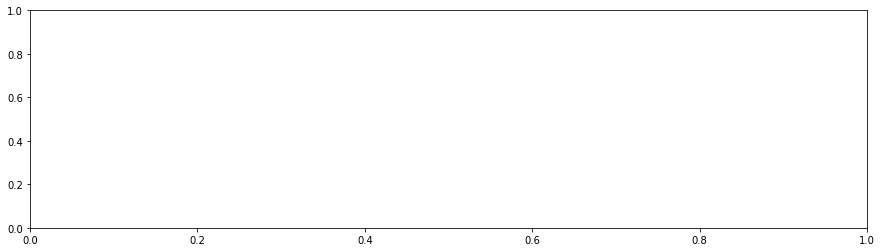

In [343]:
res=df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Южный компонент'].mean().reset_index(name='Average')
cond1 = (df['Time'].dt.hour >= start_po_vremeni) & (df['Time'].dt.hour < end_po_vremeni) 
df = df.loc[cond1, ]
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Температура'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Температура',figsize=(15,4))

ModuleNotFoundError: No module named 'pandas.plotting._timeseries'

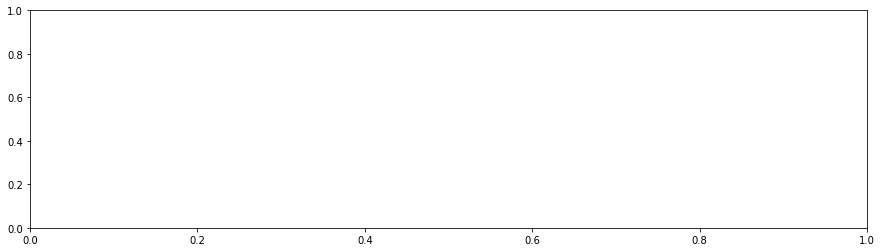

In [344]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Температура'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Температура',figsize=(15,4))

In [ ]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Южный компонент'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Южный компонент',figsize=(15,4))

In [ ]:
len(res)

In [ ]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Восточный компонент'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Восточный компонент',figsize=(15,4))

In [ ]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Вертикальный компонент'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Вертикальный компонент',figsize=(15,4)) 

In [ ]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Атмосферное давление'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Атмосферное давление',figsize=(15,4))

In [ ]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Влажность воздуха'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Влажность воздуха',figsize=(15,4))

In [400]:
import plotly.graph_objects as go
import pandas as pd
df_data = df
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/vortex.csv")

fig = go.Figure(data = go.Cone(
    x=df['x'],
    y=df['y'],
    z=df['z'],
    u=df['u'],
    v=df['v'],
    w=df['w'],
    colorscale='Blues',
    sizemode="absolute",
    sizeref=40))

fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=0.8),
                             camera_eye=dict(x=1.2, y=1.2, z=0.6)))

fig.show()

In [401]:
for i in range(2000):
    df['u'][i]= u_df[i]
    df['v'][i]= v_df[i]
    df['w'][i]= w_df[i]
  

In [403]:
fig = go.Figure(data = go.Cone(
    x=df['x'],
    y=df['y'],
    z=df['z'],
    u=df['u'],
    v=df['v'],
    w=df['w'],
    colorscale='Blues',
    sizemode="absolute",
    sizeref=40))

fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=0.8),
                             camera_eye=dict(x=1.2, y=1.2, z=0.6)))

fig.show()